In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Generate synthetic multivariate time series data (e.g., 3 features per timestep)
def create_multivariate_data(n_samples=1000, timesteps=30, n_features=3):
    np.random.seed(42)
    normal_data = np.random.normal(loc=0, scale=1, size=(n_samples, timesteps, n_features))
    
    # Introduce anomalies by adding larger values at random timesteps
    anomalies = normal_data.copy()
    anomalies[500:510] += np.random.normal(loc=10, scale=5, size=(10, timesteps, n_features))  # Add anomalies

    return normal_data, anomalies

In [3]:
# Load and scale data
normal_data, anomalies = create_multivariate_data()
scaler = MinMaxScaler()
normal_data = scaler.fit_transform(normal_data.reshape(-1, normal_data.shape[-1])).reshape(normal_data.shape)
anomalies = scaler.transform(anomalies.reshape(-1, anomalies.shape[-1])).reshape(anomalies.shape)

In [4]:
# Model parameters
timesteps = normal_data.shape[1]
n_features = normal_data.shape[2]

In [23]:
from tensorflow.keras.layers import Masking
model = Sequential([
    Masking(mask_value=np.nan, input_shape=(timesteps, n_features)),  # Mask NaNs
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 30, 3)             0         
                                                                 
 lstm_213 (LSTM)             (None, 30, 64)            17408     
                                                                 
 dropout_104 (Dropout)       (None, 30, 64)            0         
                                                                 
 lstm_214 (LSTM)             (None, 32)                12416     
                                                                 
 repeat_vector_53 (RepeatVe  (None, 30, 32)            0         
 ctor)                                                           
                                                                 
 lstm_215 (LSTM)             (None, 30, 32)            8320      
                                                     

In [5]:
# Build LSTM Autoencoder model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 32)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            24832     
                                                                 
 time_distributed (TimeDist  (None, 30, 3)             195       
 ributed)                                             

In [24]:
# Train model on normal data only (for anomaly detection)
history = model.fit(normal_data, normal_data, epochs=20, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/20
29/29 [==============================] - 14s 88ms/step - loss: 0.1478 - val_loss: 0.0495
Epoch 2/20
29/29 [==============================] - 2s 60ms/step - loss: 0.0438 - val_loss: 0.0355
Epoch 3/20
29/29 [==============================] - 2s 59ms/step - loss: 0.0322 - val_loss: 0.0269
Epoch 4/20
29/29 [==============================] - 2s 60ms/step - loss: 0.0238 - val_loss: 0.0167
Epoch 5/20
29/29 [==============================] - 2s 59ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 6/20
29/29 [==============================] - 2s 61ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 7/20
29/29 [==============================] - 2s 60ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 8/20
29/29 [==============================] - 2s 61ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 9/20
29/29 [==============================] - 2s 60ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 10/20
29/29 [==============================] - 2s 67ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 11

In [7]:
# Define a function to detect anomalies
def detect_anomalies(data, threshold=0.01):
    # Predict and calculate MSE
    reconstructions = model.predict(data)
    mse = np.mean(np.square(data - reconstructions), axis=(1, 2))  # mean squared error per sample
    
    # Detect anomalies where MSE > threshold
    anomalies = mse > threshold
    return anomalies, mse

In [8]:
# Set a threshold (for this example, we use a sample threshold - it may need tuning)
threshold = 0.02

# Detect anomalies in both normal and anomalous datasets
normal_anomalies, normal_mse = detect_anomalies(normal_data, threshold)
anomaly_anomalies, anomaly_mse = detect_anomalies(anomalies, threshold)

print("Normal Data Anomalies Detected:", np.sum(normal_anomalies))
print("Anomalous Data Anomalies Detected:", np.sum(anomaly_anomalies))

32/32 [==============================] - 1s 21ms/step
Normal Data Anomalies Detected: 4
Anomalous Data Anomalies Detected: 14


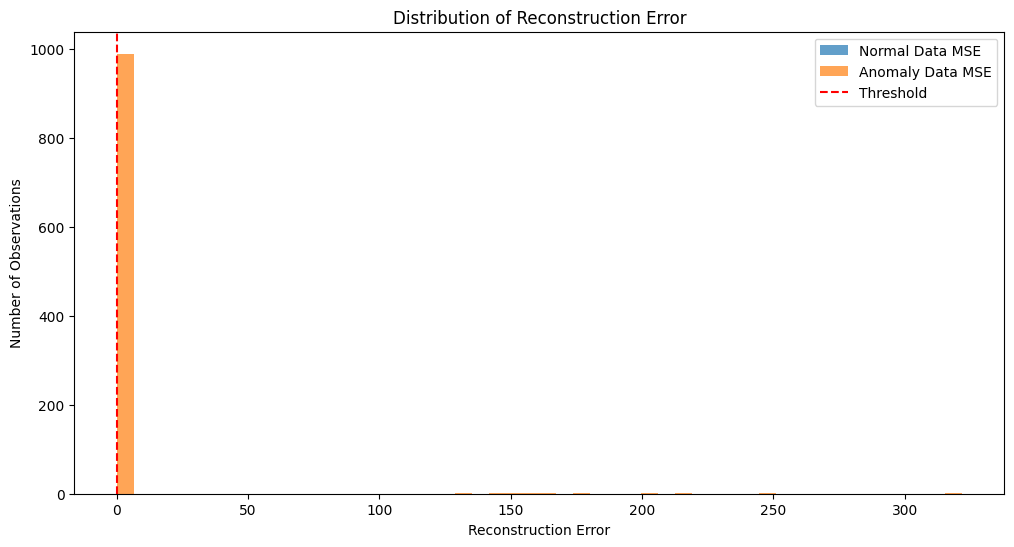

In [9]:
# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(normal_mse, bins=50, alpha=0.7, label='Normal Data MSE')
plt.hist(anomaly_mse, bins=50, alpha=0.7, label='Anomaly Data MSE')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Observations")
plt.title("Distribution of Reconstruction Error")
plt.show()

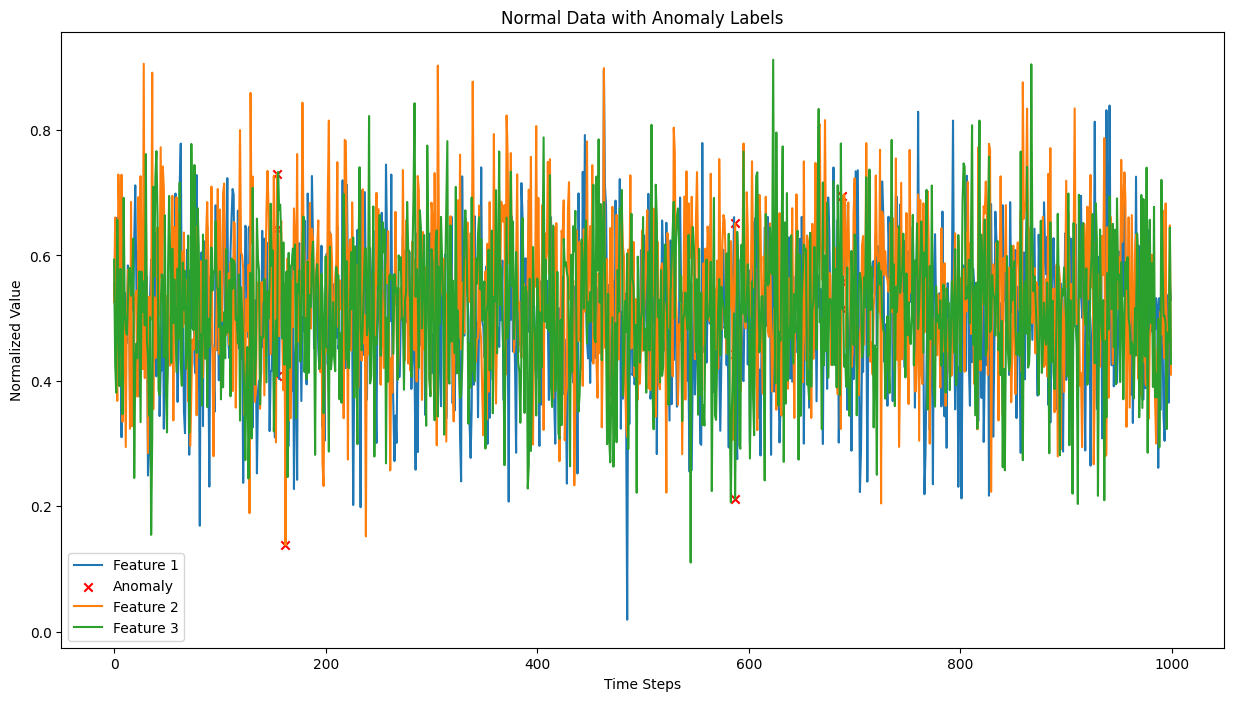

In [11]:
# Plotting the input features with anomaly labels
def plot_features_with_anomalies(data, anomalies, title="Features with Anomaly Labels"):
    plt.figure(figsize=(15, 8))
    
    # Plot each feature with anomalies marked
    for feature in range(data.shape[2]):
        plt.plot(data[:, 0, feature], label=f"Feature {feature+1}")
        
        # Mark anomalies
        plt.scatter(
            np.where(anomalies)[0], 
            data[anomalies, 0, feature], 
            color='red', label="Anomaly" if feature == 0 else "", 
            marker='x'
        )

    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.show()

# Plot features and anomalies for normal data
plot_features_with_anomalies(normal_data, normal_anomalies, title="Normal Data with Anomaly Labels")

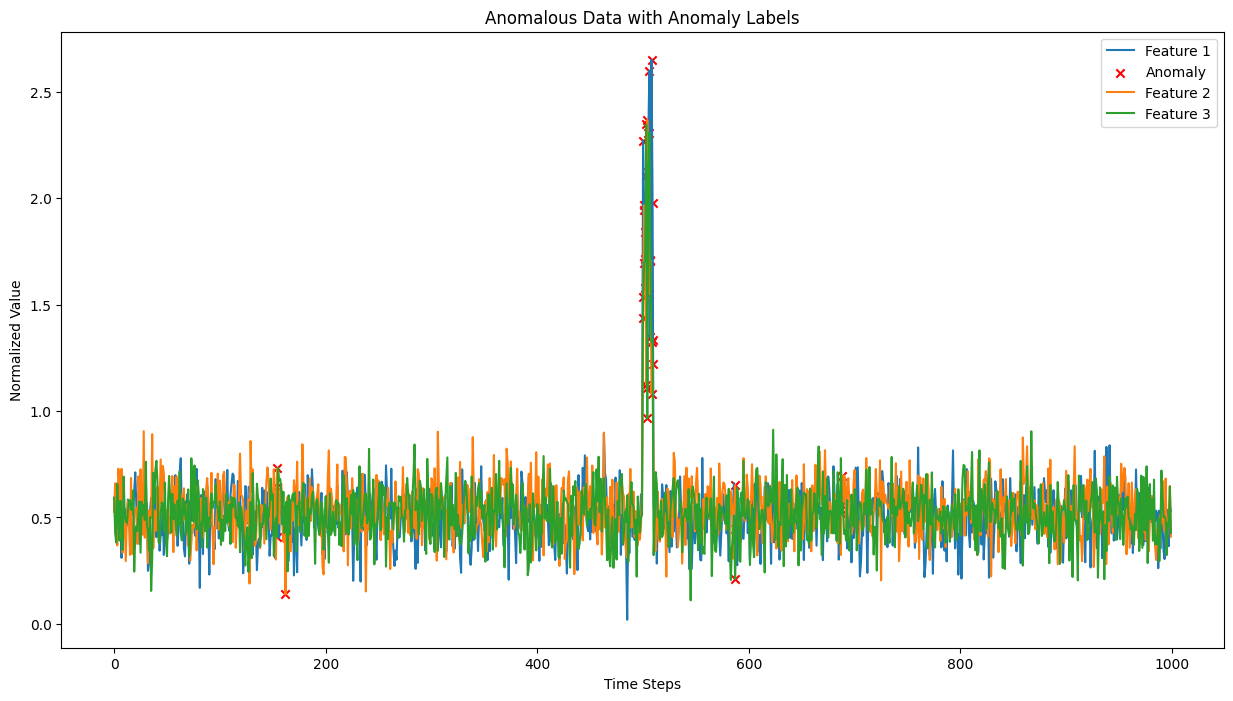

In [12]:

# Plot features and anomalies for anomalous data
plot_features_with_anomalies(anomalies, anomaly_anomalies, title="Anomalous Data with Anomaly Labels")

In [19]:
import optuna
from tensorflow.keras.optimizers import Adam
# Define Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    lstm_units_encoder = trial.suggest_int('lstm_units_encoder', 16, 128, step=16)
    lstm_units_bottleneck = trial.suggest_int('lstm_units_bottleneck', 16, 64, step=16)
    lstm_units_decoder = trial.suggest_int('lstm_units_decoder', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Build LSTM Autoencoder model
    model = Sequential([
        LSTM(lstm_units_encoder, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units_bottleneck, activation='relu', return_sequences=False),
        RepeatVector(timesteps),
        LSTM(lstm_units_bottleneck, activation='relu', return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units_decoder, activation='relu', return_sequences=True),
        TimeDistributed(Dense(n_features))
    ])

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model
    history = model.fit(
        normal_data, normal_data,
        epochs=20,  # Reduce to 20 for faster tuning
        batch_size=batch_size,
        validation_split=0.1,
        shuffle=True,
        verbose=0
    )

    # Evaluate validation loss as the metric for Optuna to optimize
    val_loss = min(history.history['val_loss'])
    return val_loss

In [20]:
# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2024-10-25 09:29:08,621] A new study created in memory with name: no-name-8db8f075-5978-4663-b9fa-9ff9817f304c
C:\Users\jedre\AppData\Local\Temp\ipykernel_23632\3841283665.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
[I 2024-10-25 09:29:41,846] Trial 0 finished with value: 0.014874137938022614 and parameters: {'lstm_units_encoder': 112, 'lstm_units_bottleneck': 64, 'lstm_units_decoder': 128, 'dropout_rate': 0.3381703785550066, 'learning_rate': 0.000389058867124049, 'batch_size': 64}. Best is trial 0 with value: 0.014874137938022614.
[I 2024-10-25 09:30:41,011] Trial 1 finished with value: 0.014920840039849281 and parameters: {'lstm_units_encoder': 112, 'lstm_units_bottleneck': 64, 'lstm_units_decoder': 96, 'dropout_rate': 0.32610393765820656, 'lear

In [21]:
study.best_params

{'lstm_units_encoder': 96,
 'lstm_units_bottleneck': 32,
 'lstm_units_decoder': 112,
 'dropout_rate': 0.03784839569450331,
 'learning_rate': 0.00044441204809339996,
 'batch_size': 32}